<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/style_transfer/style_transfer(2015).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

In [1]:
# 데이터를 저장할 폴더 생성
!mkdir data

In [2]:
cd /content/data

/content/data


In [3]:
# content, style 사진 업로드
from google.colab import files
file_uploaded = files.upload()

Saving content.jpg to content.jpg
Saving style.jpg to style.jpg


In [4]:
# content와 style 이미지 불러오기
from PIL import Image
path2content = '/content/data/content.jpg'
path2style = '/content/data/style.jpg'

content_img = Image.open(path2content)
style_img = Image.open(path2style)

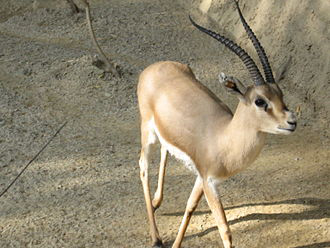

In [5]:
# content image 확인
content_img

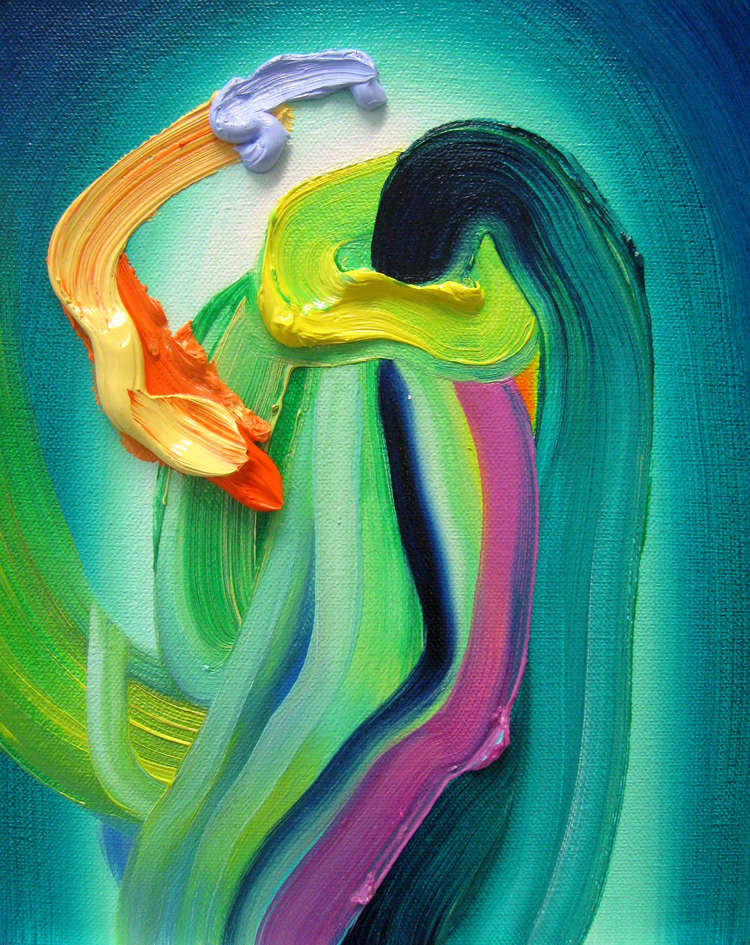

In [6]:
# style image 확인
style_img

# transformation 적용하기

In [7]:
import torchvision.transforms as transforms

h, w = 256, 384
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean_rgb, std_rgb)
])

In [8]:
# 이미지에 transformation 적용하기
content_tensor = transformer(content_img)
style_tensor = transformer(style_img)
print(content_tensor.shape, content_tensor.requires_grad)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 256, 384]) False
torch.Size([3, 256, 384]) False


In [9]:
# transformation이 적용된 image 시각화하기
import torch

def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c *= torch.tensor(std_rgb).view(3, 1,1)
    img_tensor_c += torch.tensor(mean_rgb).view(3,1,1)
    img_tensor_c = img_tensor_c.clamp(0,1)
    img_pil = to_pil_image(img_tensor_c)
    return img_pil

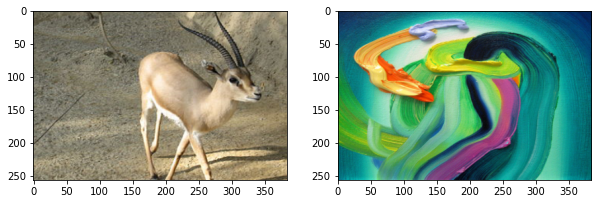

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.transforms.functional import to_pil_image

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgtensor2pil(content_tensor))
plt.subplot(1,2,2)
plt.imshow(imgtensor2pil(style_tensor))

# style transfer 구현하기

In [11]:
# pretrained VGG19를 불러옵니다
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg = models.vgg19(pretrained=True).features.to(device).eval()

# 파라미터를 freeze 합니다.
for param in model_vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


# 손실함수 정의하기

In [12]:
# style loss와 content loss를 정의하기 위해 
# 모델의 중간 feature를 얻은 후 Gram matrix를 계산해야 합니다.

# 모델의 중간 레이어의 출력값을 얻는 함수를 정의합니다.
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()): # 0, conv
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

In [24]:
# Gram matrix를 계산하는 함수를 정의합니다.
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n*c, h*w)
    gram = torch.mm(x,x.t()) # 행렬간 곱셈 수행
    return gram

In [14]:
# content loss를 계산하는 함수를 정의합니다.
import torch.nn.functional as F

def get_content_loss(pred_features, target_features, layer):
    target = target_features[layer]
    pred = pred_features[layer]
    loss = F.mse_loss(pred, target)
    return loss

In [15]:
# style loss
def get_style_loss(pred_features, target_features, style_layers_dict):
    loss = 0
    for layer in style_layers_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n, c, h, w = pred_fea.shape
        target_gram = gram_matrix(target_features[layer])
        layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)
        loss += layer_loss / (n*c*h*w)
    return loss

In [22]:
# content와 style image를 위한 feature를 얻습니다.
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg, feature_layers)
style_features = get_features(sty_tensor, model_vgg, feature_layers)

In [17]:
# content feature를 확인합니다.
for key in content_features.keys():
    print(content_features[key].shape)

torch.Size([1, 64, 256, 384])
torch.Size([1, 128, 128, 192])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 16, 24])


# optimizer 정의하기

In [18]:
# content tensor을 복사한 input tensor을 생성합니다.
input_tensor = con_tensor.clone().requires_grad_(True)

# optimizer를 정의합니다.
from torch import optim
optimizer = optim.Adam([input_tensor], lr=0.01)

# 실행하기

In [19]:
# 하이퍼파라미터를 정의합니다
num_epochs = 300
content_weight = 1e1
style_weight = 1e4
content_layer = 'conv5_1'
style_layers_dict = {'conv1_1':0.75,
                     'conv2_1':0.5,
                     'conv3_1':0.25,
                     'conv4_1':0.25,
                     'conv5_1':0.25}

In [31]:
# style transfer
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    input_features = get_features(input_tensor, model_vgg, feature_layers) # feature_layers에 해당하는 layer의 출력값 얻기
    content_loss = get_content_loss(input_features, content_features, content_layer) # 
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    neural_loss = content_weight * content_loss + style_weight * style_loss
    neural_loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 100 == 0:
        print('epoch {}, content loss: {:.2}, style loss: {:.2}'.format(epoch, content_loss, style_loss))

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])


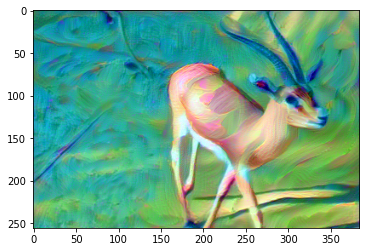

In [26]:
# 결과 시각화
plt.imshow(imgtensor2pil(input_tensor[0].cpu()))